# Automated methods to detect pneumonia diseases from medical images
Notebook to train a CNN model to predict whether a Chest X-Ray is for a person without Pneumonia vs. a person with Pneumonia.

## Import libraries

In [ ]:
# Install required libraries
#!pip install kaggle kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, LayerNormalization, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping
import os
import tensorflow as tf
import numpy as np
import random
import kagglehub
import zipfile

## Seeding the data to make it reproducible

In [ ]:
# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Downloading the Kaggle dataset

In [ ]:
# Download the dataset from Kaggle
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Dataset downloaded to:", dataset_path)

# Extract the dataset
dataset_dir = os.path.join(dataset_path, "chest_xray")
if not os.path.exists(dataset_dir):
    with zipfile.ZipFile(dataset_path + ".zip", 'r') as zip_ref:
        zip_ref.extractall(dataset_path)

# Define the main dataset directory
base_dir = os.path.join(dataset_path, "chest_xray")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Check the structure of the dataset
print(f"Training set: {len(os.listdir(train_dir + '/NORMAL'))} normal, {len(os.listdir(train_dir + '/PNEUMONIA'))} pneumonia")
print(f"Validation set: {len(os.listdir(val_dir + '/NORMAL'))} normal, {len(os.listdir(val_dir + '/PNEUMONIA'))} pneumonia")
print(f"Test set: {len(os.listdir(test_dir + '/NORMAL'))} normal, {len(os.listdir(test_dir + '/PNEUMONIA'))} pneumonia")

100%|██████████| 2.29G/2.29G [00:18<00:00, 132MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Training set: 1341 normal, 3875 pneumonia
Validation set: 8 normal, 8 pneumonia
Test set: 234 normal, 390 pneumonia


## Create data generators to generate batches of the image data

In [ ]:
# Image dimensions and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


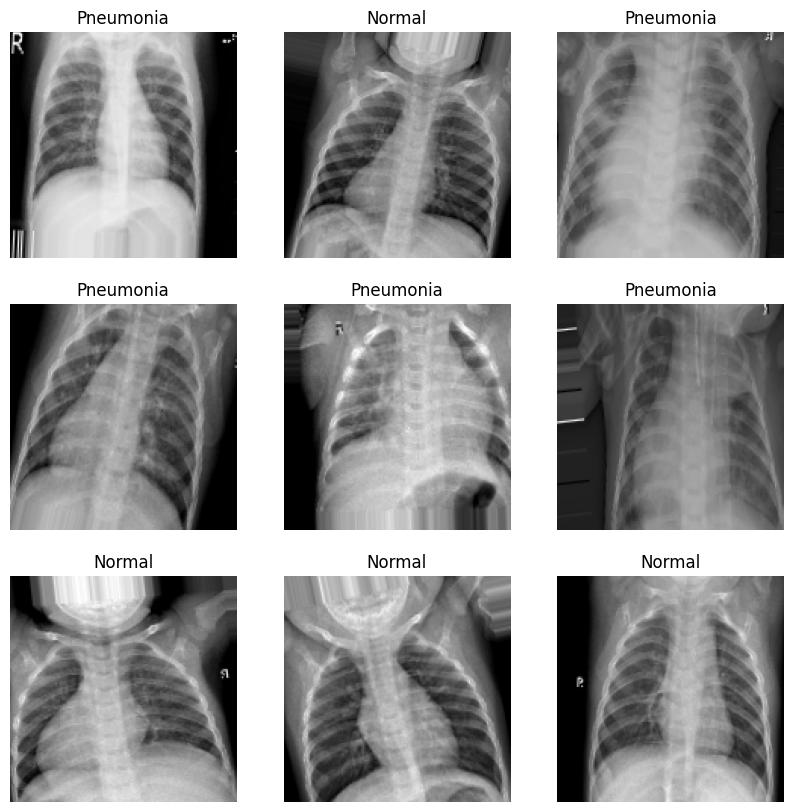

In [ ]:
# Visualize sample images
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title("Pneumonia" if labels[i] else "Normal")
        plt.axis("off")
    plt.show()

plot_images(train_generator)

## Create Model Function

This function's purpose is support training models with varying model parameters in a consistent manner by simply passing in different function parameters. Example usage:

create_model(dropout_rate=0.2, activation='leaky_relu', padding='valid')

This will train a CNN model with 3 convolutional-pooling blocks (default), dropout rate of 0.2 (different from default value of 0.5), activation function of leaky_relu (different from default value of 'relu'), and padding of valid (different from default value of same).

In [ ]:
def create_model(num_blocks=3, activation='relu', use_batchnorm=True, dropout_rate=0.5, use_l2_reg=False,
                 conv_strides=(1,1), padding='same', use_avg_pooling=False, use_layer_norm=False,
                 input_shape=(150, 150, 3)):
    """
    Creates a Convolutional Neural Network model with configurable architecture and activation functions.

    Parameters:
        num_blocks (int): Number of convolutional blocks to include in the model (default is 3).
        activation (str): Activation function to use. Supported options are 'relu', 'leaky_relu', 'selu', and 'elu'.
        use_batchnorm (bool): Whether to use Batch Normalization after convolution layers (default is True).
        dropout_rate (float): Dropout rate for the fully connected layers (default is 0.5).
        use_l2_reg (bool): Whether to apply L2 regularization to convolutional layers (default is False).
        conv_strides (tuple): Strides for the convolutional layers (default is (1,1)).
        padding (str): Padding type for convolutional layers (default is 'same').
        use_avg_pooling (bool): Whether to use AveragePooling instead of MaxPooling (default is False).
        use_layer_norm (bool): Whether to use Layer Normalization instead of Batch Normalization (default is False).
        input_shape (tuple): Shape of the input data (default is (150, 150, 3)).

    Returns:
        model (tf.keras.Sequential): Compiled Keras Sequential model.
    """
    def get_activation_layer(act):
        if act == 'leaky_relu':
            return LeakyReLU(alpha=0.1)
        elif act in ('relu', 'selu', 'elu'):
            return Activation(act)
        else:
            raise ValueError("Unsupported activation function. Choose one of: 'relu', 'leaky_relu', 'selu', or 'elu'")

    model = Sequential()
    model.add(Input(shape=input_shape))

    # First Convolutional Layer (Input Layer)
    model.add(Conv2D(32, (3, 3), padding=padding, strides=conv_strides))
    model.add(get_activation_layer(activation))

    # Use AveragePooling or MaxPooling
    if use_avg_pooling:
        model.add(AveragePooling2D(pool_size=(2, 2)))
    else:
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add normalization if requested
    if use_layer_norm:
        model.add(LayerNormalization())
    elif use_batchnorm:
        model.add(BatchNormalization())

    # Additional Convolutional Blocks
    filters = 64
    for _ in range(num_blocks - 1):
        reg = l2(0.001) if use_l2_reg else None
        model.add(Conv2D(filters, (3, 3), padding=padding, strides=conv_strides, kernel_regularizer=reg))
        model.add(get_activation_layer(activation))

        # Use AveragePooling or MaxPooling
        if use_avg_pooling:
            model.add(AveragePooling2D(pool_size=(2, 2)))
        else:
            model.add(MaxPooling2D(pool_size=(2, 2)))

        # Add normalization if requested
        if use_layer_norm:
            model.add(LayerNormalization())
        elif use_batchnorm:
            model.add(BatchNormalization())

        filters *= 2  # Increase filter size per block

    # Fully Connected Layers
    model.add(Flatten())
    # First Dense Layer
    if activation == 'leaky_relu':
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))

    # Second Dense Layer
    if activation == 'leaky_relu':
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))  # Binary Classification Output

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

## Function to show layer redundancy

This function provides a visual representation of the similarity of the various feature maps from each layer.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity

def analyze_redundant_filters(model):
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            weights, _ = layer.get_weights()  # Get weights (kernels)
            num_filters = weights.shape[-1]  # Number of filters
            flattened_filters = weights.reshape(-1, num_filters)  # Flatten each filter

            # Compute pairwise cosine similarity
            similarity_matrix = cosine_similarity(flattened_filters.T)

            # Plot similarity heatmap
            plt.figure(figsize=(8, 6))
            plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.title(f"Filter Similarity in Layer: {layer.name}")
            plt.xlabel("Filter Index")
            plt.ylabel("Filter Index")
            plt.show()

## Function to plot training history

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy curves from a model's training history.

    Args:
        history: A Keras History object containing training metrics.
    """
    plt.figure(figsize=(12, 4))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.show()


##Other shared settings

In [ ]:
# Set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)

## Testing different number of convolutional-pooling building blocks

Convolutional-pooling building blocks represent the number of hidden layers where there is a convolutional layer, a pooling layer, and then a form of normalization layer sequentially. The code below tests varying numbers of these building blocks.

### Training a base model with 3 convolutional-pooling building blocks

This base model will be used as the standard to compare all future models with for the convolutional-pooling parameter and all other parameter configurations.

In [ ]:
# Train the model
base_model = create_model(num_blocks=3)

base_history = base_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = base_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 399ms/step - accuracy: 0.7826 - loss: 0.5625 - val_accuracy: 0.5000 - val_loss: 5.2678
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.8660 - loss: 0.2824 - val_accuracy: 0.5000 - val_loss: 6.5180
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.8986 - loss: 0.2495 - val_accuracy: 0.5000 - val_loss: 3.9831
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.9154 - loss: 0.2243 - val_accuracy: 0.6250 - val_loss: 1.4409
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.9057 - loss: 0.2521 - val_accuracy: 0.6875 - val_loss: 0.8284
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.9182 - loss: 0.2041 - val_accuracy: 0.6250 - val_loss: 0.9949
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.9169 - loss: 0.2215 - val_accuracy: 0.7500 - val_loss: 0.4914
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.9206 - loss: 0

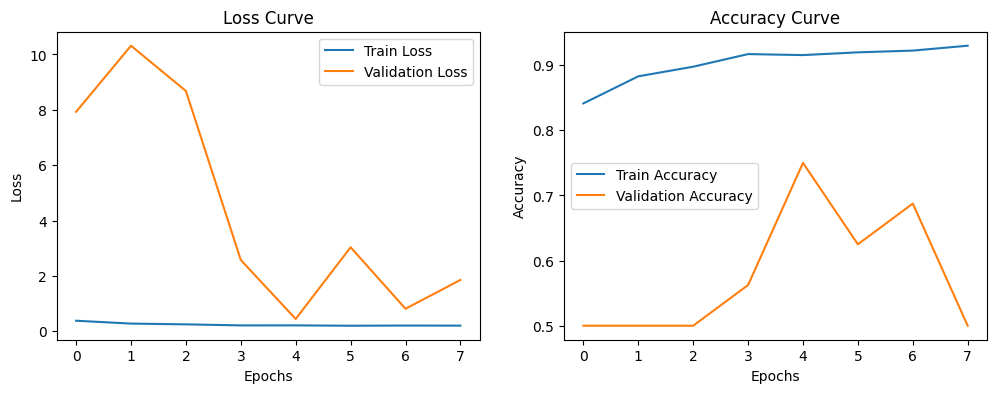

In [ ]:
plot_training_history(base_history)

In [ ]:
# Save the trained model
base_model.save("base_cnn_model.h5")

### Training a model with 4 convolutional-pooling building blocks

In [ ]:
# Train the model
four_convolution_blocks_model = create_model(num_blocks=4)
four_convolution_blocks_history = four_convolution_blocks_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = four_convolution_blocks_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 405ms/step - accuracy: 0.8212 - loss: 0.4572 - val_accuracy: 0.5000 - val_loss: 5.3972
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.8938 - loss: 0.2496 - val_accuracy: 0.5000 - val_loss: 9.2577
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.9109 - loss: 0.2150 - val_accuracy: 0.5000 - val_loss: 5.4760
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.9165 - loss: 0.2265 - val_accuracy: 0.5625 - val_loss: 3.2676
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9240 - loss: 0.2166 - val_accuracy: 0.5000 - val_loss: 4.4323
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.9339 - loss: 0.1785 - val_accuracy: 0.5625 - val_loss: 1.3533
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 400ms/step - accuracy: 0.9418 - loss: 0.1613 - val_accuracy: 0.7500 - val_loss: 0.4793
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.9447 - loss: 0

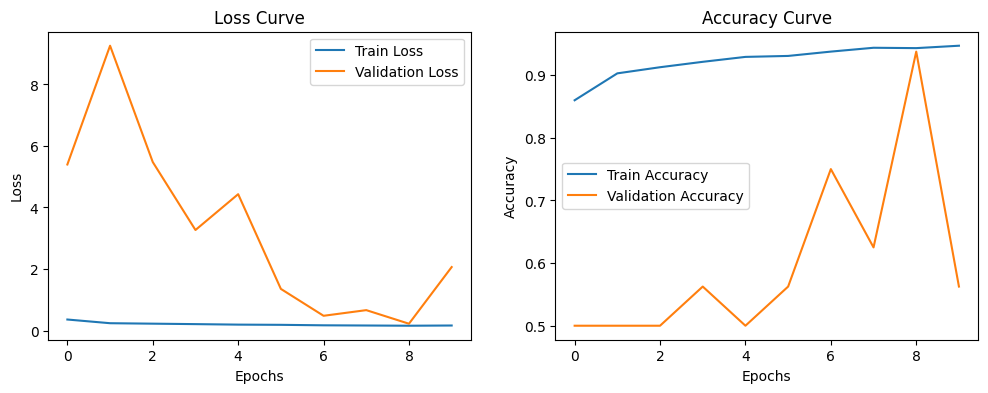

In [ ]:
plot_training_history(four_convolution_blocks_history)

In [ ]:
# Save the trained model
four_convolution_blocks_model.save("four_convolutional_blocks_cnn_model.h5")

### Training a model with 5 convolutional-pooling building blocks

In [ ]:
# Train the model
five_convolution_blocks_model = create_model(num_blocks=5)
five_convolution_blocks_history = five_convolution_blocks_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = five_convolution_blocks_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 403ms/step - accuracy: 0.7950 - loss: 0.4646 - val_accuracy: 0.5000 - val_loss: 3.5700
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 404ms/step - accuracy: 0.9031 - loss: 0.2456 - val_accuracy: 0.5000 - val_loss: 5.8772
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9173 - loss: 0.2100 - val_accuracy: 0.5000 - val_loss: 2.9020
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.9290 - loss: 0.1851 - val_accuracy: 0.6250 - val_loss: 0.9008
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9365 - loss: 0.1682 - val_accuracy: 0.5000 - val_loss: 0.7077
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 400ms/step - accuracy: 0.9363 - loss: 0.1767 - val_accuracy: 0.5000 - val_loss: 1.6405
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9358 - loss: 0.1657 - val_accuracy: 0.7500 - val_loss: 0.6445
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.9483 - loss: 0

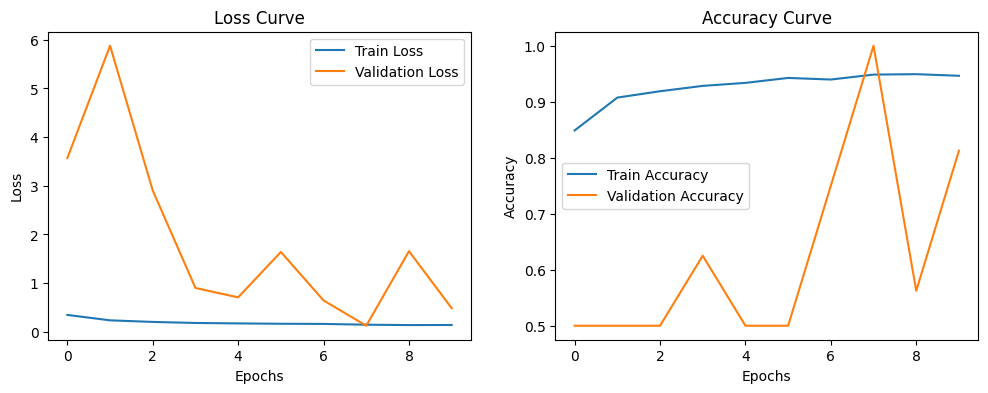

In [ ]:
plot_training_history(five_convolution_blocks_history)

In [ ]:
# Save the trained model
five_convolution_blocks_model.save("five_convolutional_blocks_cnn_model.h5")

### Training a model with 2 convolutional-pooling building blocks

In [ ]:
# Train the model
two_convolution_blocks_model = create_model(num_blocks=2)
two_convolution_blocks_history = two_convolution_blocks_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = two_convolution_blocks_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 402ms/step - accuracy: 0.7455 - loss: 0.7408 - val_accuracy: 0.5000 - val_loss: 2.2768
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.8460 - loss: 0.3357 - val_accuracy: 0.5000 - val_loss: 4.5896
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 389ms/step - accuracy: 0.8531 - loss: 0.3023 - val_accuracy: 0.5000 - val_loss: 4.6888
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.8789 - loss: 0.2742 - val_accuracy: 0.6875 - val_loss: 0.7235
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.8871 - loss: 0.2658 - val_accuracy: 0.6250 - val_loss: 1.9497
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9050 - loss: 0.2457 - val_accuracy: 0.7500 - val_loss: 0.5444
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9036 - loss: 0.2382 - val_accuracy: 0.6875 - val_loss: 0.4450
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9100 - loss: 0

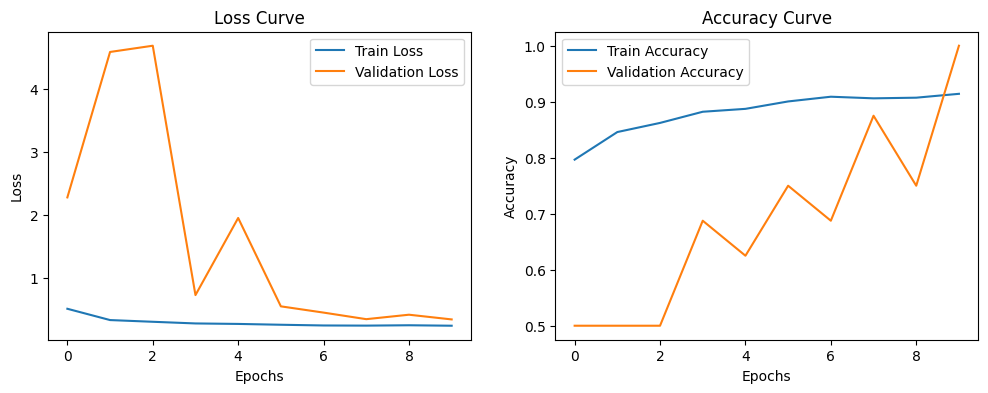

In [ ]:
plot_training_history(two_convolution_blocks_history)

In [ ]:
# Save the trained model
two_convolution_blocks_model.save("two_convolutional_blocks_cnn_model.h5")

## Strides
Below is the code to experiment with different strides.

### Training model with with strides = (1,1)

In [ ]:
# Train the model
base_model = create_model(conv_strides=(1,1))


base_model_history = base_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = base_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 397ms/step - accuracy: 0.7994 - loss: 0.5133 - val_accuracy: 0.5000 - val_loss: 5.1317
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 389ms/step - accuracy: 0.8765 - loss: 0.2863 - val_accuracy: 0.5000 - val_loss: 5.1431
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.8861 - loss: 0.2744 - val_accuracy: 0.5000 - val_loss: 4.3927
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.8985 - loss: 0.2559 - val_accuracy: 0.6875 - val_loss: 1.1246
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9135 - loss: 0.2219 - val_accuracy: 0.6875 - val_loss: 2.0348
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 389ms/step - accuracy: 0.9225 - loss: 0.1993 - val_accuracy: 0.5625 - val_loss: 2.3282
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 415ms/step - accuracy: 0.9208 - loss: 0.2100 - val_accuracy: 0.6875 - val_loss: 0.6978
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.9202 - loss: 0

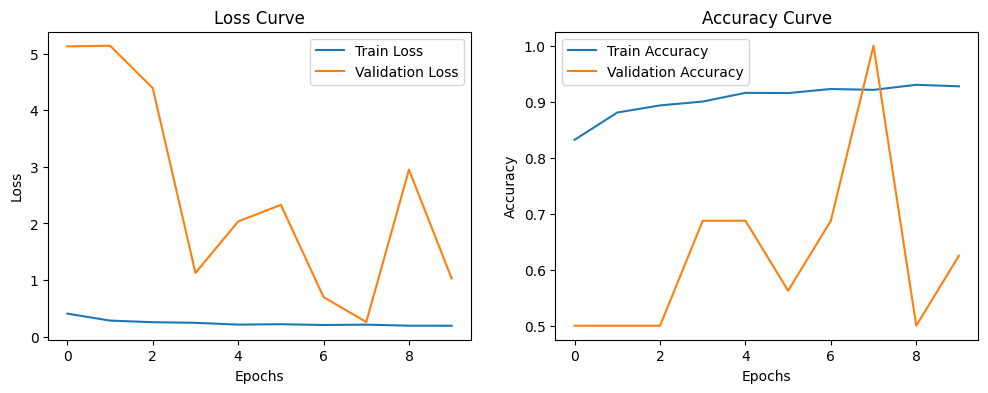

In [ ]:
plot_training_history(base_model_history)

### Training model with strides = (2,2)

In [ ]:
# Train the model
different_stride_version_two_model = create_model(conv_strides=(2,2))

different_stride_version_two_model_history = different_stride_version_two_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = different_stride_version_two_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 388ms/step - accuracy: 0.7315 - loss: 0.5931 - val_accuracy: 0.5000 - val_loss: 1.5934
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.8271 - loss: 0.3821 - val_accuracy: 0.5000 - val_loss: 2.8993
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 384ms/step - accuracy: 0.8601 - loss: 0.3153 - val_accuracy: 0.5000 - val_loss: 2.1216
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 385ms/step - accuracy: 0.8787 - loss: 0.2622 - val_accuracy: 0.6875 - val_loss: 0.6073
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 386ms/step - accuracy: 0.8886 - loss: 0.2566 - val_accuracy: 0.6250 - val_loss: 1.2837
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.9000 - loss: 0.2252 - val_accuracy: 0.7500 - val_loss: 0.5045
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 381ms/step - accuracy: 0.9022 - loss: 0.2242 - val_accuracy: 0.9375 - val_loss: 0.2663
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 382ms/step - accuracy: 0.9204 - loss: 0

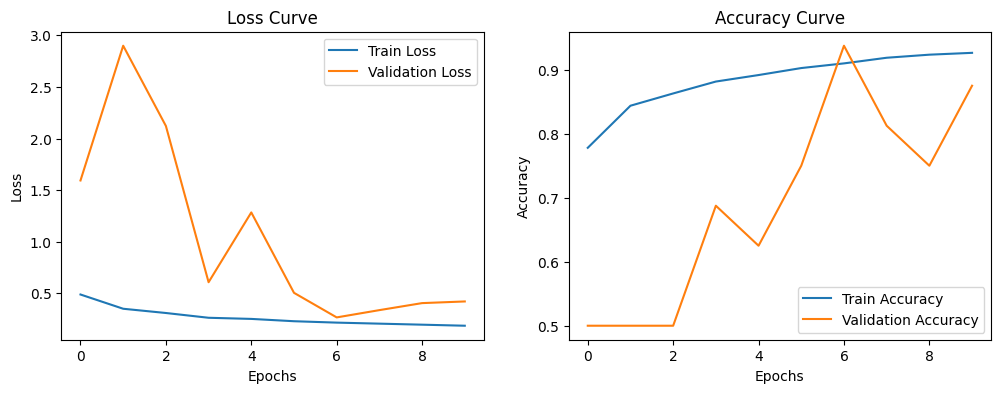

In [ ]:
plot_training_history(different_stride_version_two_model_history)

### Training model with strides = (3,3)

In [ ]:
different_stride_version_three_model = create_model(conv_strides=(3,3))


different_stride_version_three_model_history = different_stride_version_three_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = different_stride_version_three_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 388ms/step - accuracy: 0.6461 - loss: 0.6966 - val_accuracy: 0.5000 - val_loss: 1.3136
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 384ms/step - accuracy: 0.7793 - loss: 0.4534 - val_accuracy: 0.5000 - val_loss: 2.6950
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 379ms/step - accuracy: 0.8323 - loss: 0.3629 - val_accuracy: 0.5000 - val_loss: 2.0490
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.8565 - loss: 0.3166 - val_accuracy: 0.5625 - val_loss: 1.3420
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.2984 - loss: 1.8040
Test Accuracy: 62.50%


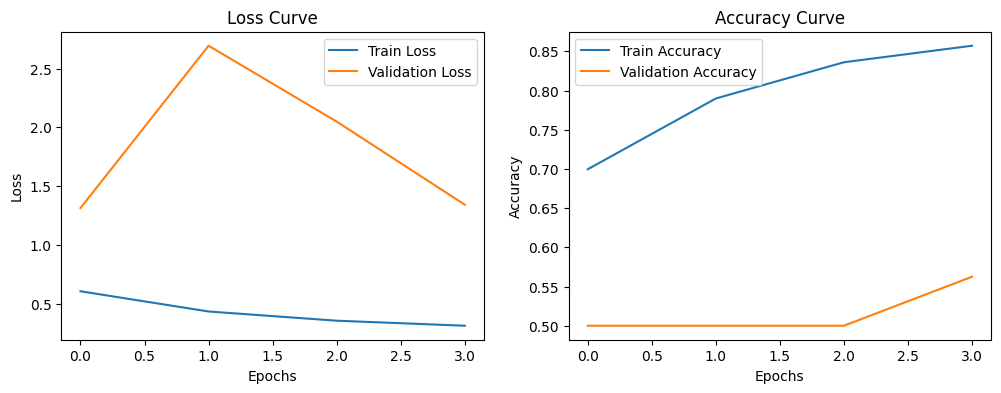

In [ ]:
plot_training_history(different_stride_version_three_model_history)

## Padding

### Training model with padding = 'valid'
Valid padding will prevent zeros being added to the resultant feature set
matrices.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.7997 - loss: 0.4907 - val_accuracy: 0.5000 - val_loss: 6.5561
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 435ms/step - accuracy: 0.8872 - loss: 0.2722 - val_accuracy: 0.5000 - val_loss: 8.0518
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 434ms/step - accuracy: 0.9004 - loss: 0.2503 - val_accuracy: 0.5000 - val_loss: 6.5110
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 438ms/step - accuracy: 0.9217 - loss: 0.2153 - val_accuracy: 0.5625 - val_loss: 5.0037
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 425ms/step - accuracy: 0.9261 - loss: 0.2074 - val_accuracy: 0.6250 - val_loss: 1.2439
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.9258 - loss: 0.1950 - val_accuracy: 0.6250 - val_loss: 1.7455
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9349 - loss: 0.1833 - val_accuracy: 0.6250 - val_loss: 1.1951
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 419ms/step - accuracy: 0.9324 - loss: 0

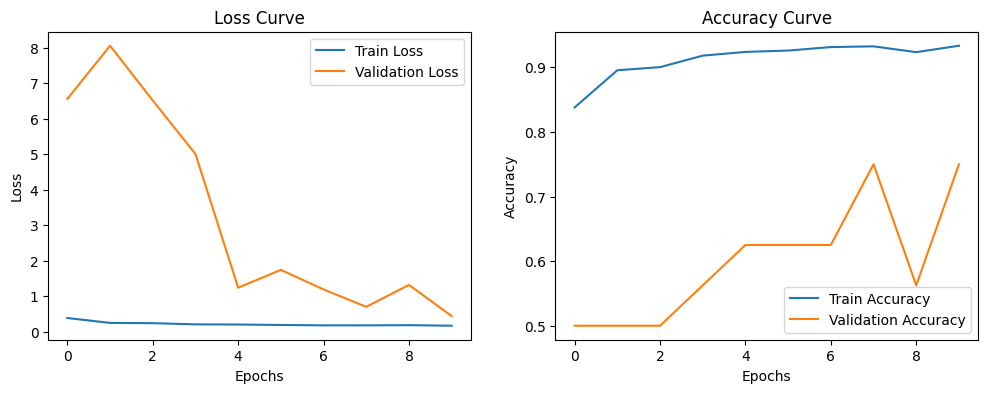

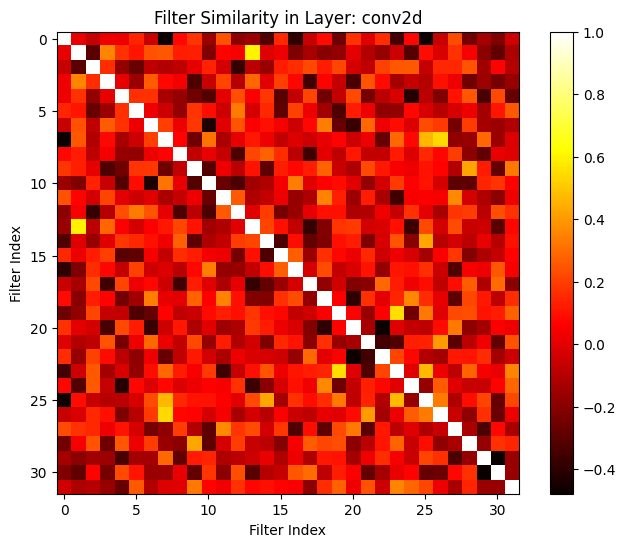

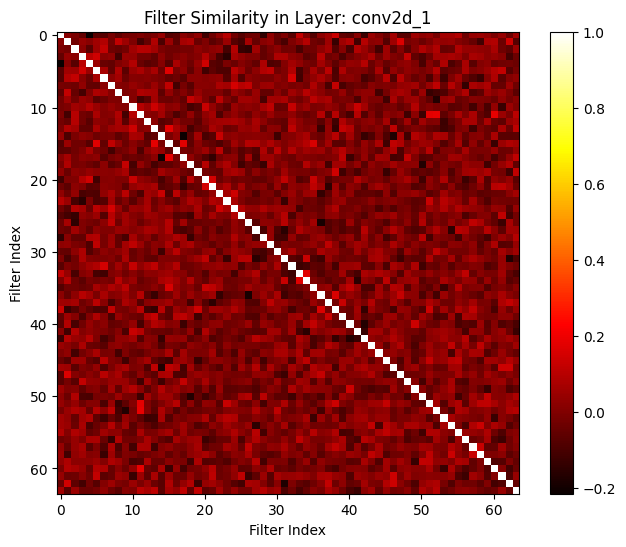

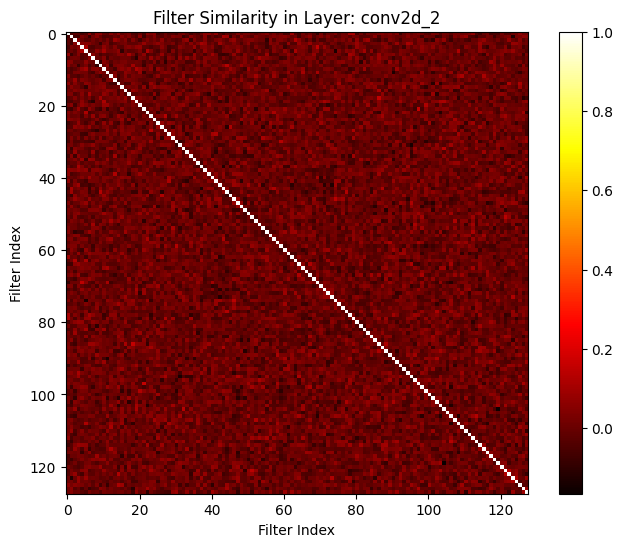

In [ ]:
# Padding = 'valid'
model_padding_valid = create_model(num_blocks=3, padding='valid')

history_padding_valid = model_padding_valid.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate on test set
loss_padding_valid, acc_padding_valid = model_padding_valid.evaluate(test_generator)
print(f"Test Accuracy: {acc_padding_valid*100:.2f}%")
plot_training_history(history_padding_valid)
analyze_redundant_filters(model_padding_valid)

## Transfer Learning
Here we experiment with transfer learning, to see if this provides any
improvements over what we've seen so far. We need to convert the
images to RGB for compatibility with the VGG16 model, and then
freeze the base model we use to prevent re-training of the
transferred model itself. We add our own layers for training.

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 473ms/step - accuracy: 0.5976 - loss: 0.7496 - val_accuracy: 0.5000 - val_loss: 0.6280
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 450ms/step - accuracy: 0.7738 - loss: 0.4650 - val_accuracy: 0.6875 - val_loss: 0.5360
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 446ms/step - accuracy: 0.8382 - loss: 0.3525 - val_accuracy: 0.6875 - val_loss: 0.5122
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 442ms/step - accuracy: 0.8564 - loss: 0.3210 - val_accuracy: 0.6875 - val_loss: 0.5197
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 446ms/step - accuracy: 0.8662 - loss: 0.2959 - val_accuracy: 0.6875 - val_loss: 0.5103
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 475ms/step - accuracy: 0.8848 - loss: 0.2770 - val_accuracy: 0.8125 - val_loss: 0.3820
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 489ms/step - accuracy: 0.9023 - loss: 0.2489 - val_accuracy: 0.7500 - val_loss: 0.4551
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 483ms/step - accuracy: 0.9010 - loss: 

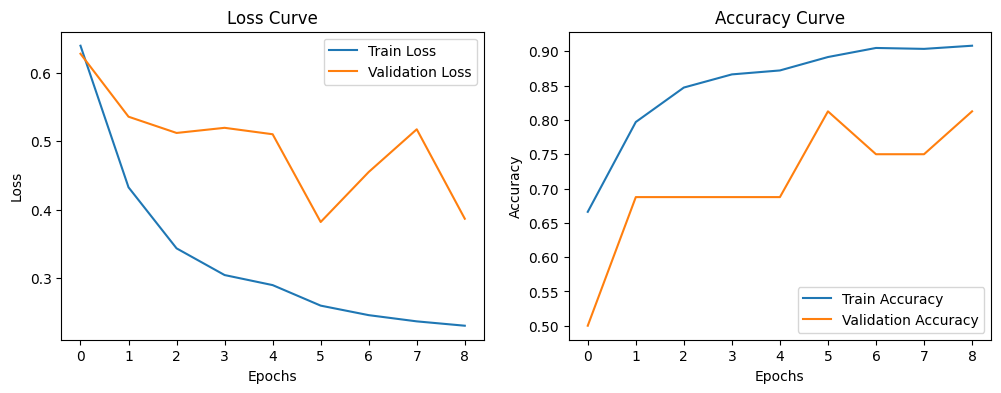

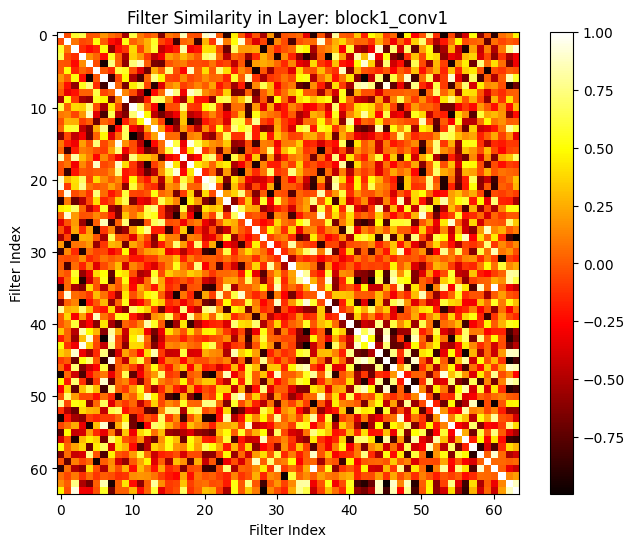

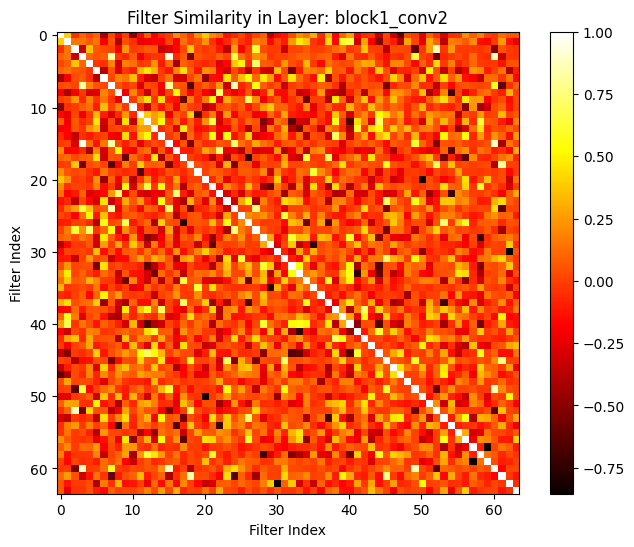

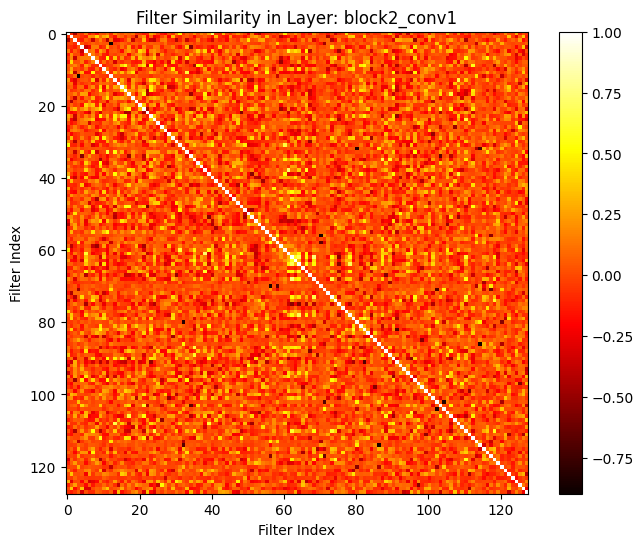

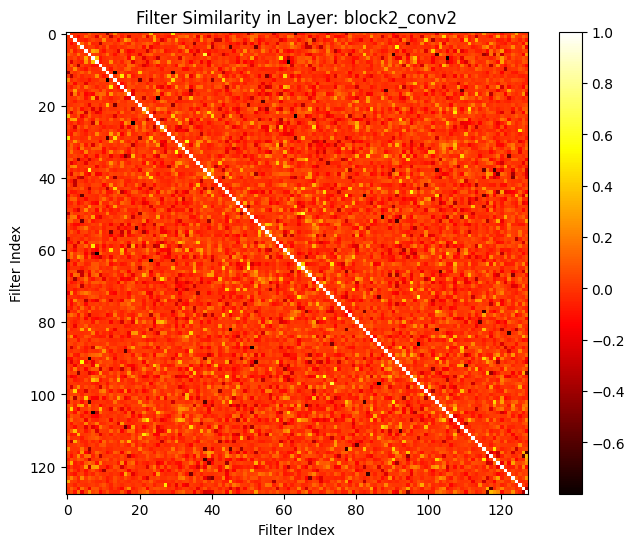

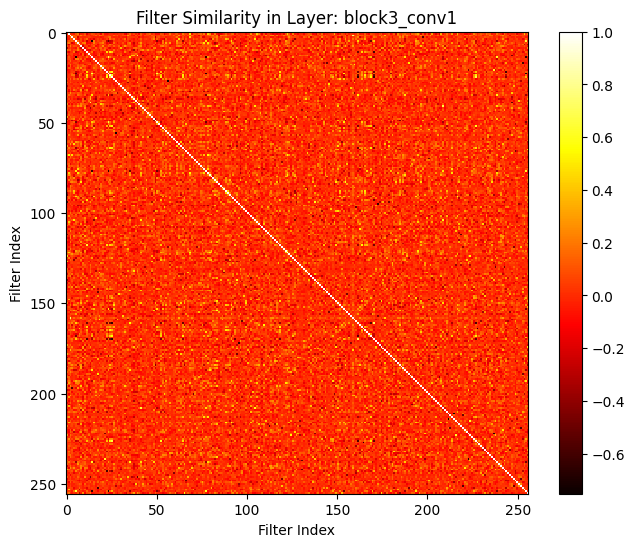

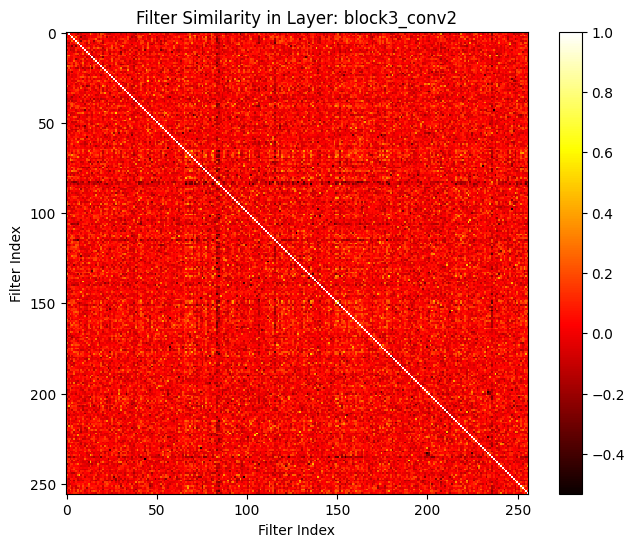

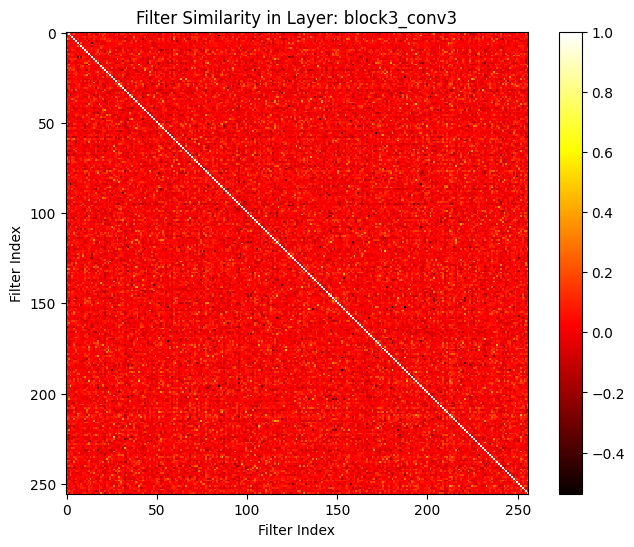

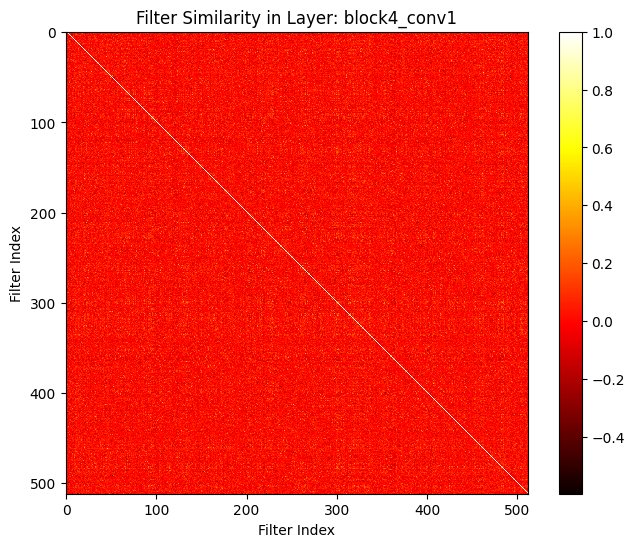

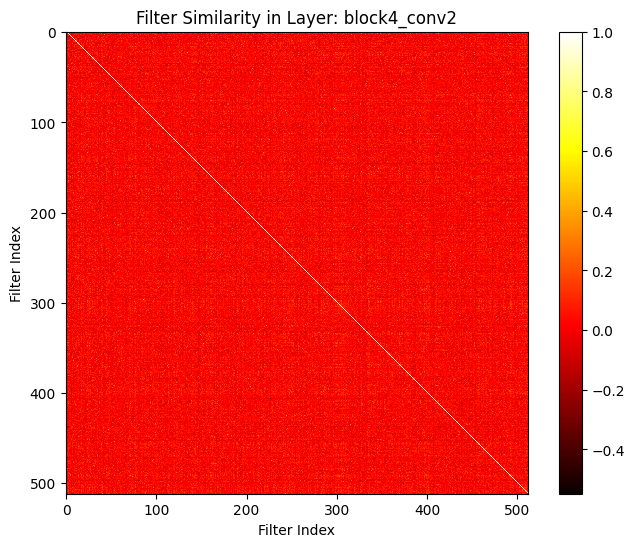

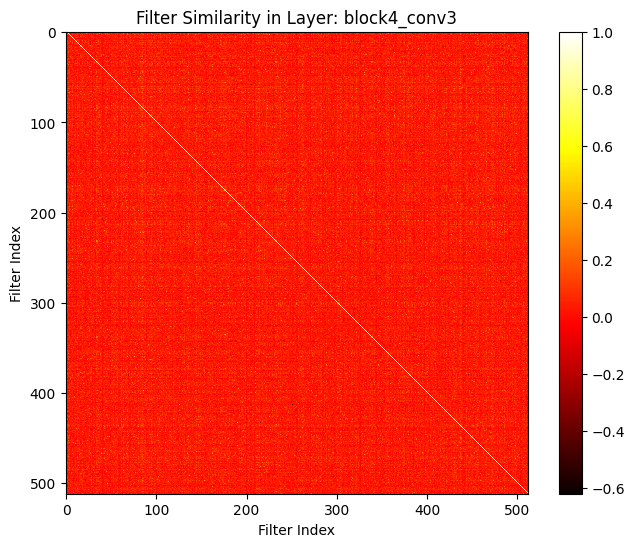

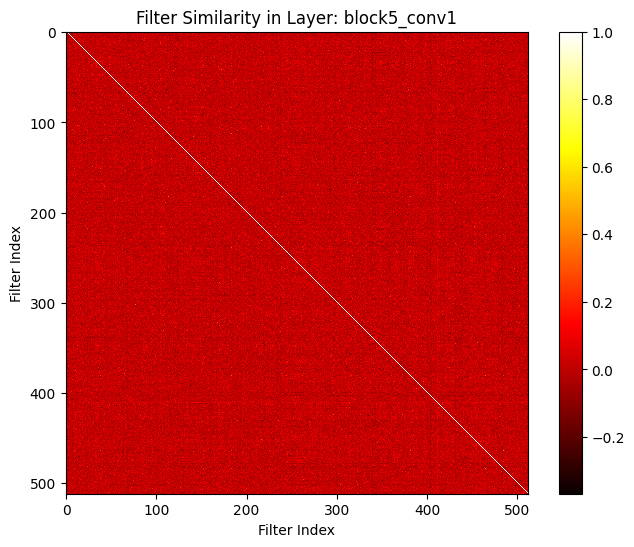

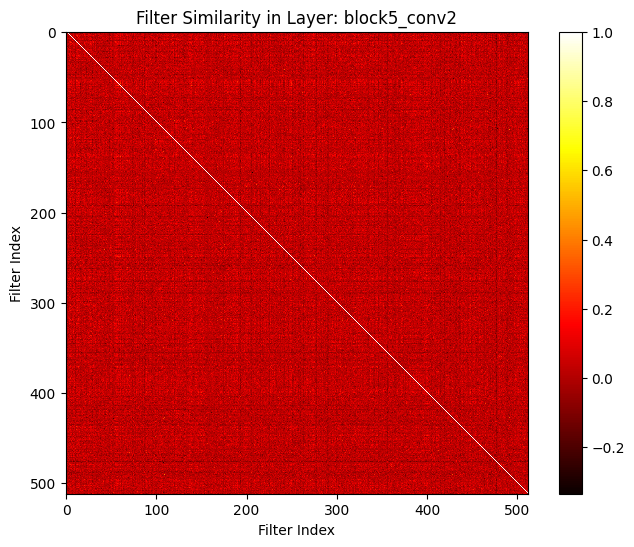

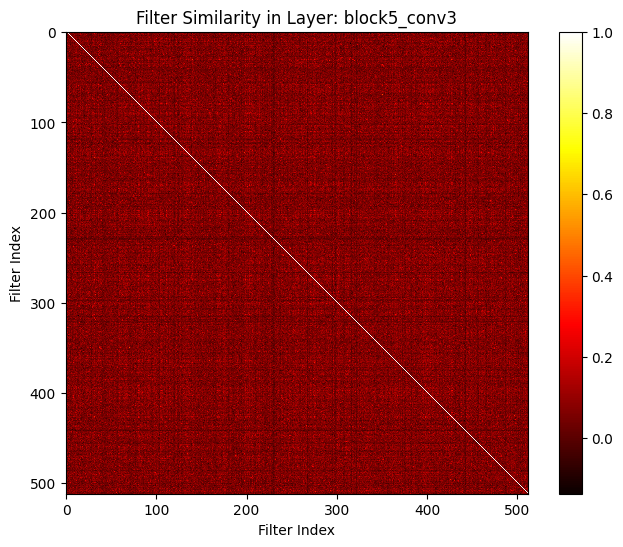

In [ ]:
# Compare with pre-trained model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np

# Load images from directories with RGB conversion for compatibility with VGG16
train_generator_pt = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

val_generator_pt = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_generator_pt = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# Load VGG16 without the top layer as we don't need to classify on ImageNet images
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers so they are not trained initially
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model_pt = Model(inputs=base_model.input, outputs=output_layer)

model_pt.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_pt = model_pt.fit(
    train_generator_pt,
    validation_data=val_generator_pt,
    epochs=10,
    callbacks=[early_stopping]
)

loss_pt, acc_pt = model_pt.evaluate(test_generator_pt)
print(f"Test Accuracy: {acc_pt*100:.2f}%")

plot_training_history(history_pt)
analyze_redundant_filters(model_pt)


## Different Image Sizes
The raw images are around 2000px in size, but we resize them to 150x150 when
we load them. This likely loses some important data, so we experiment here
with a slightly larger image size to see what changes if any this makes.

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 360ms/step - accuracy: 0.7979 - loss: 0.6851 - val_accuracy: 0.5000 - val_loss: 7.7396
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 347ms/step - accuracy: 0.8625 - loss: 0.3148 - val_accuracy: 0.5000 - val_loss: 10.0286
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 342ms/step - accuracy: 0.8688 - loss: 0.3248 - val_accuracy: 0.5000 - val_loss: 3.5327
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 346ms/step - accuracy: 0.8932 - loss: 0.2714 - val_accuracy: 0.6250 - val_loss: 1.9977
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 341ms/step - accuracy: 0.9036 - loss: 0.2497 - val_accuracy: 0.6250 - val_loss: 1.7649
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 341ms/step - accuracy: 0.9087 - loss: 0.2378 - val_accuracy: 0.5000 - val_loss: 2.5873
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 352ms/step - accuracy: 0.9051 - loss: 0.2511 - val_accuracy: 0.6875 - val_loss: 1.6383
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 345ms/step - accuracy: 0.9102 - loss: 

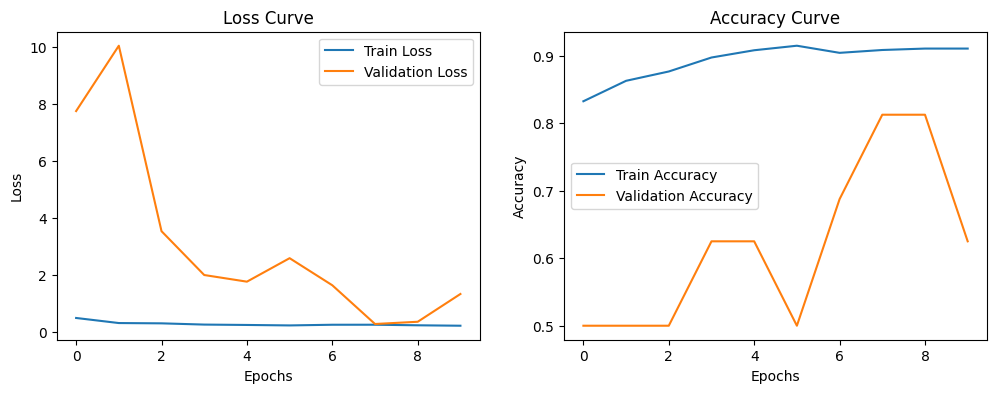

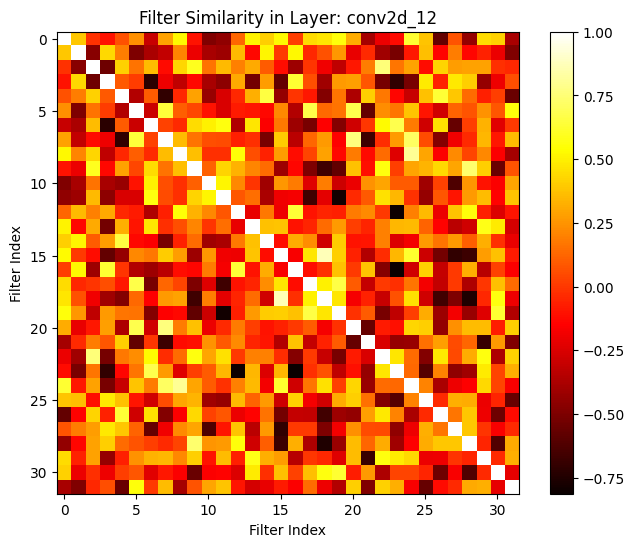

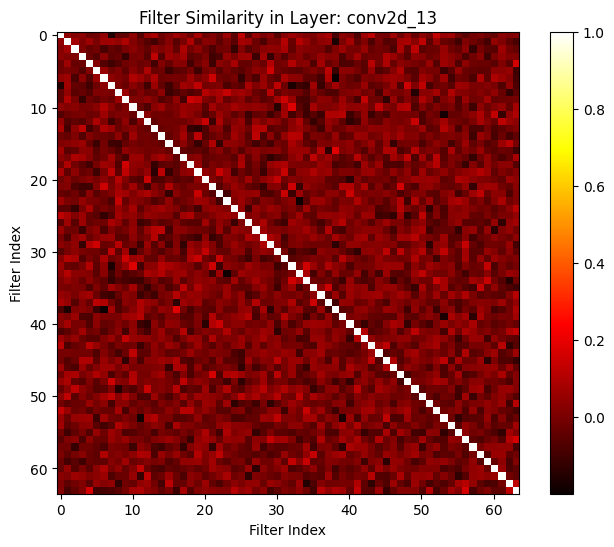

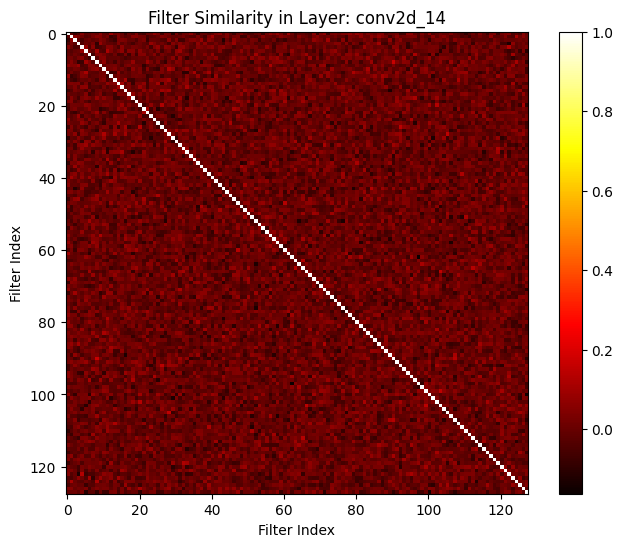

In [ ]:
# Padding = 'valid', larger image sizes

IMG_SIZE = (224, 224)

train_generator_lg = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

val_generator_lg = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

test_generator_lg = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

# Train the model
model_padding_valid_lg = create_model(num_blocks=3, padding='valid', input_shape=(224, 224, 1))

history_padding_valid_lg = model_padding_valid_lg.fit(
    train_generator_lg,
    validation_data=val_generator_lg,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate on test set
loss_padding_valid_lg, acc_padding_valid_lg = model_padding_valid_lg.evaluate(test_generator_lg)
print(f"Test Accuracy: {acc_padding_valid_lg*100:.2f}%")
plot_training_history(history_padding_valid_lg)
analyze_redundant_filters(model_padding_valid_lg)

We repeat the above experiment, but with a different validation set.

The validation set provided with the dataset itself has only 16 members, and
appears to be sometimes causing large swings in accuracy in the training. Here we try splitting
the training set itself into an 85/15 train/validation set, and see whether
that improves performance.

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 62s 403ms/step - accuracy: 0.7741 - loss: 0.6518 - val_accuracy: 0.7430 - val_loss: 2.9897
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8581 - loss: 0.3493 - val_accuracy: 0.7430 - val_loss: 4.4158
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 51s 370ms/step - accuracy: 0.8616 - loss: 0.3274 - val_accuracy: 0.7430 - val_loss: 4.5374
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 52s 375ms/step - accuracy: 0.8753 - loss: 0.2659 - val_accuracy: 0.7532 - val_loss: 1.2020
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 52s 373ms/step - accuracy: 0.8795 - loss: 0.2800 - val_accuracy: 0.8875 - val_loss: 0.2686
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 371ms/step - accuracy: 0.8887 - loss: 0.2723 - val_accuracy: 0.9246 - val_loss: 0.2132
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 52s 372ms/step - accuracy: 0.8953 - loss: 0.2308 - val_accuracy: 0.9463 - val_loss: 0.1873
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 368ms/step - accuracy: 0.9090 - loss: 0

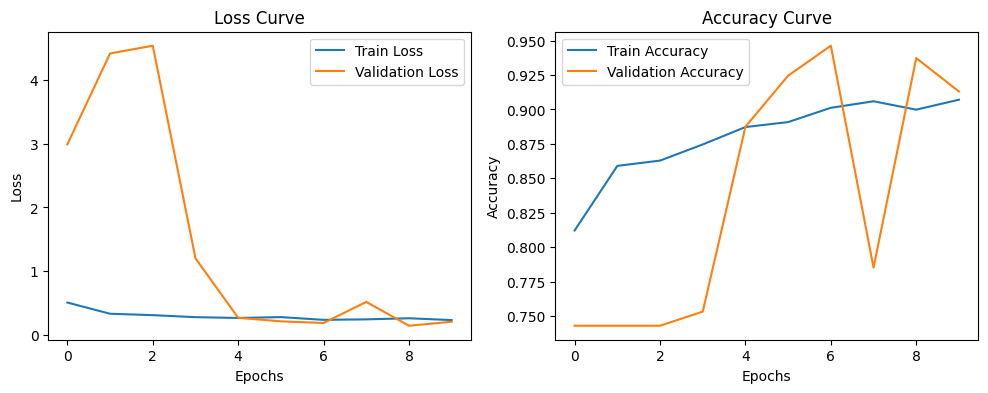

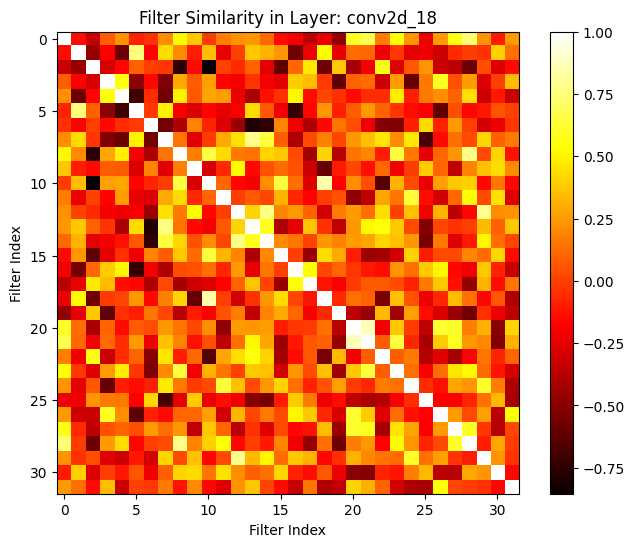

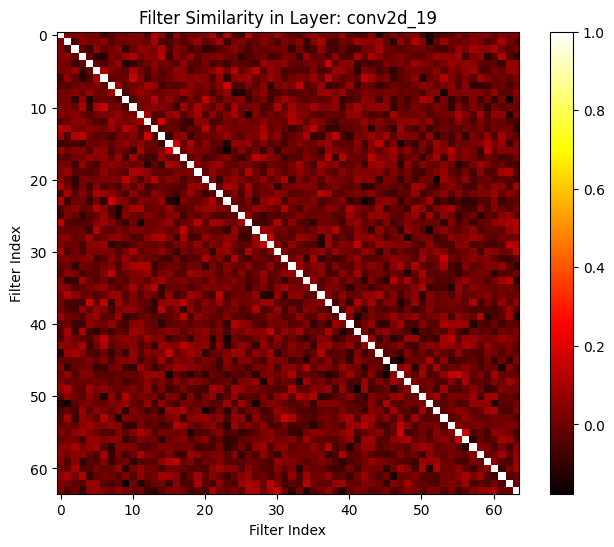

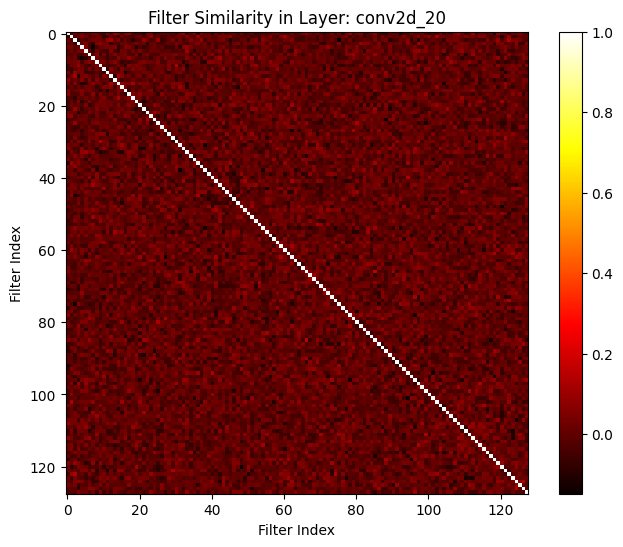

In [ ]:
# Padding = 'valid', larger image sizes, 15% validation set

IMG_SIZE = (224, 224)

train_val_datagen_valid_lg_15 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1, # with validation_split, shift properties are ignored for the validation subset
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)

test_datagen_valid_lg_15 = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator_valid_lg_15 = train_val_datagen_valid_lg_15.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    subset='training' # our training subset
)

val_generator_valid_lg_15 = train_val_datagen_valid_lg_15.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    subset='validation', # our validation subset
    shuffle=False
)

test_generator_valid_lg_15 = test_datagen_valid_lg_15.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)

# Train the model
model_padding_valid_lg_15 = create_model(num_blocks=3, padding='valid', input_shape=(224, 224, 1))

history_padding_valid_lg_15 = model_padding_valid_lg_15.fit(
    train_generator_valid_lg_15,
    validation_data=val_generator_valid_lg_15,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate on test set
loss_padding_valid_lg_15, acc_padding_valid_lg_15 = model_padding_valid_lg_15.evaluate(test_generator_valid_lg_15)
print(f"Test Accuracy: {acc_padding_valid_lg_15*100:.2f}%")
plot_training_history(history_padding_valid_lg_15)
analyze_redundant_filters(model_padding_valid_lg_15)

## Overfitting techniques
To handle the overfitting in X-ray classification we will use different strategies such as dropout_rate=0.5, MaxPooling2D,BatchNormalization and L2 regularization in addition to the previously used Augmentation and earlystopping. also we will show how we fine tune these parameters

### Train with AveragePooling instead of MaxPooling

In [ ]:
#train 3 convolutional-pooling building blocks
# same as previous parameter except cahnging MaxPooling to AveragePooling

average_pooling_model = create_model(num_blocks=3, use_avg_pooling=True)

# Set up EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)

average_pooling_history = average_pooling_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = average_pooling_model.evaluate(test_generator)
# show result
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 406ms/step - accuracy: 0.7494 - loss: 0.6065 - val_accuracy: 0.5000 - val_loss: 1.7462
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.8760 - loss: 0.2816 - val_accuracy: 0.5000 - val_loss: 2.8223
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.8927 - loss: 0.2700 - val_accuracy: 0.5000 - val_loss: 2.2315
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9043 - loss: 0.2513 - val_accuracy: 0.8750 - val_loss: 0.3200
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 405ms/step - accuracy: 0.9256 - loss: 0.2031 - val_accuracy: 0.8750 - val_loss: 0.4385
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 401ms/step - accuracy: 0.9119 - loss: 0.2360 - val_accuracy: 0.6250 - val_loss: 0.6513
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.9152 - loss: 0.2234 - val_accuracy: 0.6250 - val_loss: 0.6153
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


### Train with L2 Regularization

In [ ]:
#train 3 convolutional-pooling building blocks

# Train the model  with 3 conv and l2 regularization
l2_model = create_model(num_blocks=3, use_l2_reg=True)
# Set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)
l2_history = l2_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = l2_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 495ms/step - accuracy: 0.8005 - loss: 0.6087 - val_accuracy: 0.5000 - val_loss: 7.0092
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0.8719 - loss: 0.4130 - val_accuracy: 0.5000 - val_loss: 9.9246
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 580ms/step - accuracy: 0.8909 - loss: 0.3803 - val_accuracy: 0.5000 - val_loss: 7.2927
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 491ms/step - accuracy: 0.9207 - loss: 0.3398 - val_accuracy: 0.5000 - val_loss: 4.3616
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 475ms/step - accuracy: 0.9299 - loss: 0.3141 - val_accuracy: 0.6875 - val_loss: 0.6218
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 473ms/step - accuracy: 0.9196 - loss: 0.3283 - val_accuracy: 0.5000 - val_loss: 4.5011
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 469ms/step - accuracy: 0.9244 - loss: 0.3346 - val_accuracy: 0.6250 - val_loss: 0.8470
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.9299 - loss: 0

### Train with dropout rate of 0.2 instead of 0.5

In [ ]:
#train 3 convolutional-pooling building blocks

# Train the model  with 3 conv and dropout rate of 0.2
low_dropout_model = create_model(num_blocks=3, dropout_rate=0.2)
# Set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)
low_dropout_history = low_dropout_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = low_dropout_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 397ms/step - accuracy: 0.8578 - loss: 0.3605 - val_accuracy: 0.5000 - val_loss: 4.5785
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9283 - loss: 0.1800 - val_accuracy: 0.5000 - val_loss: 6.1828
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 401ms/step - accuracy: 0.9369 - loss: 0.1642 - val_accuracy: 0.5000 - val_loss: 3.1179
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.9342 - loss: 0.1767 - val_accuracy: 0.6875 - val_loss: 0.8586
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.9419 - loss: 0.1526 - val_accuracy: 0.6250 - val_loss: 1.4166
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9532 - loss: 0.1396 - val_accuracy: 0.7500 - val_loss: 0.5672
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.9525 - loss: 0.1326 - val_accuracy: 0.6250 - val_loss: 1.3389
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 402ms/step - accuracy: 0.9554 - loss: 0

### Train with LayerNormalization instead of BatchNormalization

In [ ]:
#train 3 convolutional-pooling building blocks

# Train the model  with 3 conv. Use layernorm and not batchnorm
layer_norm_model = create_model(num_blocks=3, use_batchnorm=False, use_layer_norm=True)
# Set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)
layer_norm_history = layer_norm_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = layer_norm_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 402ms/step - accuracy: 0.6592 - loss: 0.8343 - val_accuracy: 0.5000 - val_loss: 0.6421
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 400ms/step - accuracy: 0.7288 - loss: 0.5428 - val_accuracy: 0.5000 - val_loss: 0.6260
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.7242 - loss: 0.4916 - val_accuracy: 0.5625 - val_loss: 0.6734
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.7752 - loss: 0.4082 - val_accuracy: 0.7500 - val_loss: 0.6992
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.7832 - loss: 0.3910 - val_accuracy: 0.8125 - val_loss: 0.6886
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.2984 - loss: 0.9826
Test Accuracy: 62.50%


## Activation functions

Training the model with different activation functions.

The activation functions used include relu, leaky_relu, elu, and selu. These will be explained in the report.

The base model in the convolutional-pooling block section already trains a model with relu by default so will show the other activation functions below.

### Leaky ReLU

In [ ]:
leaky_relu_model=create_model(num_blocks=3, activation='leaky_relu')

#set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)

leaky_relu_history = leaky_relu_model.fit(train_generator,
                  validation_data=val_generator,
                   epochs=10,
                  callbacks=[early_stopping])

# Evaluate on test set
loss, acc = leaky_relu_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 474ms/step - accuracy: 0.8046 - loss: 0.5186 - val_accuracy: 0.5000 - val_loss: 5.1190
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 481ms/step - accuracy: 0.8783 - loss: 0.3131 - val_accuracy: 0.5000 - val_loss: 4.9666
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 475ms/step - accuracy: 0.8948 - loss: 0.2612 - val_accuracy: 0.5625 - val_loss: 0.8379
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 479ms/step - accuracy: 0.9107 - loss: 0.2292 - val_accuracy: 0.5625 - val_loss: 1.7977
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.9203 - loss: 0.2338 - val_accuracy: 0.6250 - val_loss: 1.7270
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 474ms/step - accuracy: 0.9147 - loss: 0.2480 - val_accuracy: 0.9375 - val_loss: 0.4069
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - accuracy: 0.9210 - loss: 0.2139 - val_accuracy: 0.5625 - val_loss: 2.3821
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 475ms/step - accuracy: 0.9274 - loss: 0

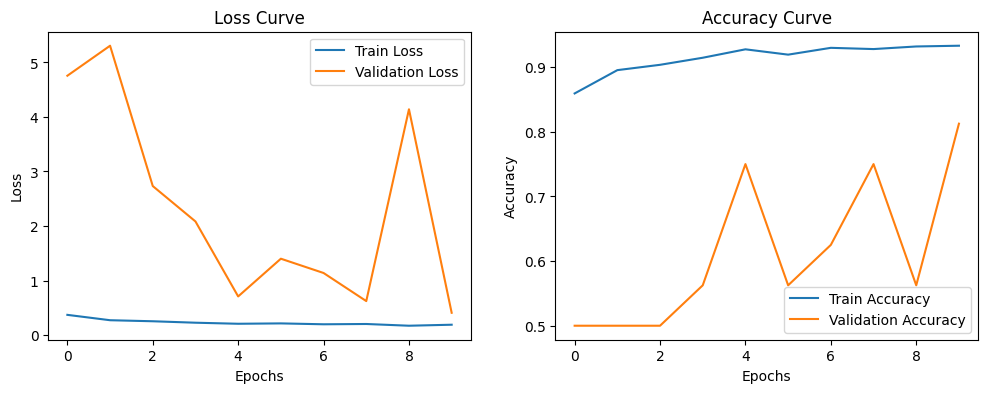

In [ ]:
plot_training_history(leaky_relu_history)

In [ ]:
# Save the trained model
leaky_relu_model.save("leaky_relu_model.h5")

### ReLU

In [ ]:
relu_model=create_model(num_blocks=3, activation='relu')

#set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)
relu_history = relu_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = relu_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 457ms/step - accuracy: 0.7889 - loss: 0.5185 - val_accuracy: 0.5000 - val_loss: 4.6763
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 407ms/step - accuracy: 0.8760 - loss: 0.2992 - val_accuracy: 0.5000 - val_loss: 6.0975
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 402ms/step - accuracy: 0.8994 - loss: 0.2568 - val_accuracy: 0.5000 - val_loss: 5.3046
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9036 - loss: 0.2358 - val_accuracy: 0.6875 - val_loss: 1.5541
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9082 - loss: 0.2345 - val_accuracy: 0.6875 - val_loss: 0.9857
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 401ms/step - accuracy: 0.9319 - loss: 0.1779 - val_accuracy: 0.7500 - val_loss: 0.4336
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.9153 - loss: 0.2287 - val_accuracy: 0.7500 - val_loss: 0.4627
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9361 - loss: 0

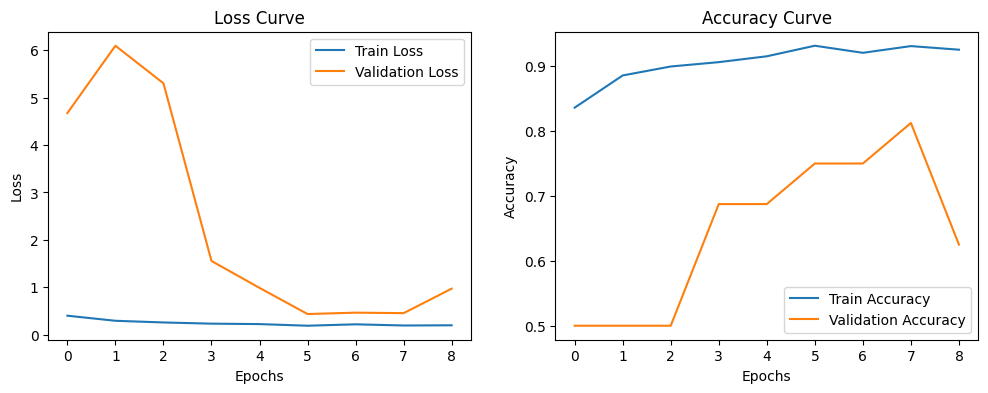

In [ ]:
plot_training_history(relu_history)

In [ ]:
# Save the trained model
relu_model.save("relu_model.h5")

### SELU

In [ ]:
selu_model=create_model(num_blocks=3, activation='selu')

#set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)
selu_history = selu_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = selu_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 397ms/step - accuracy: 0.8110 - loss: 0.8251 - val_accuracy: 0.5000 - val_loss: 8.3705
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 396ms/step - accuracy: 0.8701 - loss: 0.5483 - val_accuracy: 0.5000 - val_loss: 6.7203
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 393ms/step - accuracy: 0.8738 - loss: 0.5199 - val_accuracy: 0.5000 - val_loss: 3.9246
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.8865 - loss: 0.4796 - val_accuracy: 0.6250 - val_loss: 2.7916
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.8981 - loss: 0.3763 - val_accuracy: 0.8125 - val_loss: 0.4420
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.8993 - loss: 0.3344 - val_accuracy: 0.6250 - val_loss: 1.7767
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 391ms/step - accuracy: 0.8934 - loss: 0.3872 - val_accuracy: 0.6250 - val_loss: 2.8395
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.8974 - loss: 0

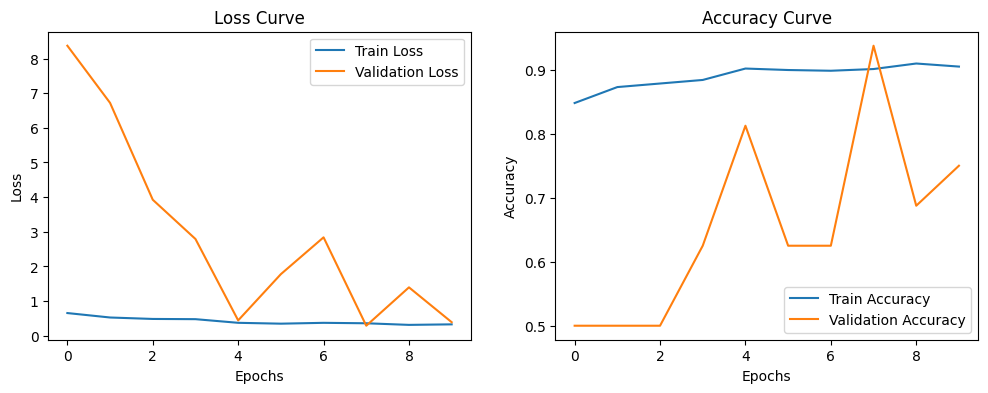

In [ ]:
plot_training_history(selu_history)

In [ ]:
# Save the trained model
selu_model.save("selu_model.h5")

### ELU

In [ ]:
elu_model=create_model(num_blocks=3, activation='elu')

#set up EarlyStopping to halt when val_loss stops improving after 3 consecutive epochs return higher validation loss than before
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True,verbose=1)
elu_history = elu_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = elu_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 397ms/step - accuracy: 0.8196 - loss: 0.5953 - val_accuracy: 0.5000 - val_loss: 7.0966
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.8700 - loss: 0.3650 - val_accuracy: 0.5000 - val_loss: 5.5818
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.8893 - loss: 0.2794 - val_accuracy: 0.5000 - val_loss: 2.3285
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.9106 - loss: 0.2700 - val_accuracy: 0.7500 - val_loss: 0.4402
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.8830 - loss: 0.3194 - val_accuracy: 0.7500 - val_loss: 0.4749
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.9098 - loss: 0.2428 - val_accuracy: 0.5625 - val_loss: 2.2134
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.9159 - loss: 0.2284 - val_accuracy: 0.6875 - val_loss: 0.6859
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


In [ ]:
plot_training_history(elu_history)

In [ ]:
# Save the trained model
elu_model.save("elu_model.h5")

### Compare activation function performances

Test Accuracy with ReLU: 92.54%
Test Accuracy with Leaky_ReLU: 93.31%
Test Accuracy with SELU: 90.49%
Test Accuracy with ELU: 92.12%


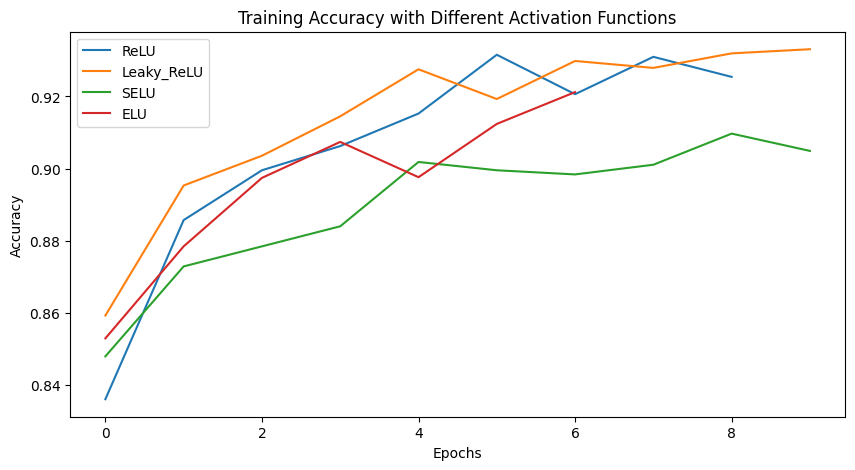

In [ ]:
histories = {"ReLU": relu_history, "Leaky_ReLU": leaky_relu_history, "SELU": selu_history, "ELU": elu_history}
# Plot accuracy comparison
plt.figure(figsize=(10, 5))
for model_name in histories:
    #acc = histories[model_name].history['accuracy']
    test_loss, test_acc = histories[model_name].model.evaluate(test_generator)
    #final_acc = acc[-1]  # Get the final epoch's accuracy
    print(f"Test Accuracy with {model_name}: {test_acc*100:.2f}%")
    plt.plot(acc, label=model_name)

plt.title("Test Accuracy with Different Activation Functions")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Best combined model

Will use the best parameters for every section and combine them into a single model.

Best model parameters are:
1. 4 Convolutional-Pooling building blocks
2. Stride of (1,1)
3. Valid padding
4. MaxPooling2D
5. No L2 Regularization
6. BatchNormalization
7. Dropout of 0.5
7. ReLU

In [ ]:
best_combined_model = create_model(num_blocks=4, conv_strides=(1,1), padding='valid', use_avg_pooling=False, use_l2_reg=False, use_batchnorm=True, activation='relu')

best_combined_history = best_combined_model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    callbacks=[early_stopping])

# Evaluate on test set
loss, acc = best_combined_model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 445ms/step - accuracy: 0.8203 - loss: 0.4496 - val_accuracy: 0.5000 - val_loss: 5.7122
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 411ms/step - accuracy: 0.8860 - loss: 0.2614 - val_accuracy: 0.5000 - val_loss: 7.7042
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9139 - loss: 0.2252 - val_accuracy: 0.5000 - val_loss: 6.6768
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9115 - loss: 0.2142 - val_accuracy: 0.5625 - val_loss: 4.4965
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 413ms/step - accuracy: 0.9235 - loss: 0.1962 - val_accuracy: 0.5625 - val_loss: 1.7803
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9265 - loss: 0.1964 - val_accuracy: 0.6250 - val_loss: 1.2222
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 417ms/step - accuracy: 0.9358 - loss: 0.1810 - val_accuracy: 0.6250 - val_loss: 0.5046
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.9345 - loss: 0

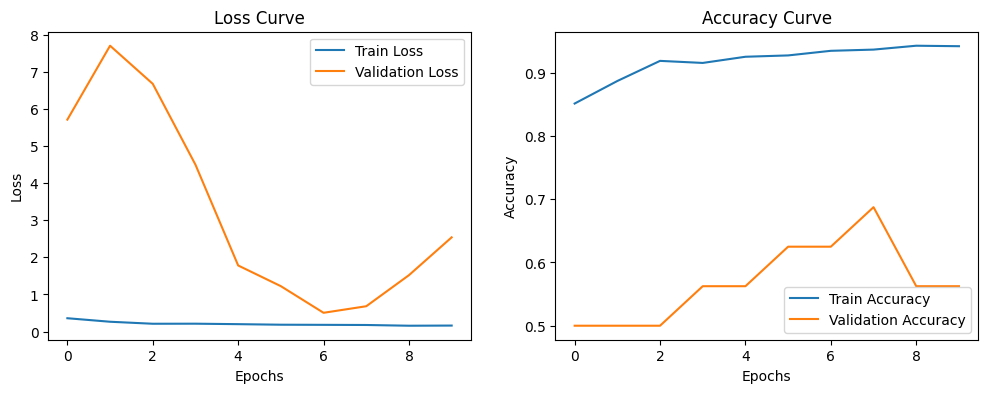

In [ ]:
plot_training_history(best_combined_history)

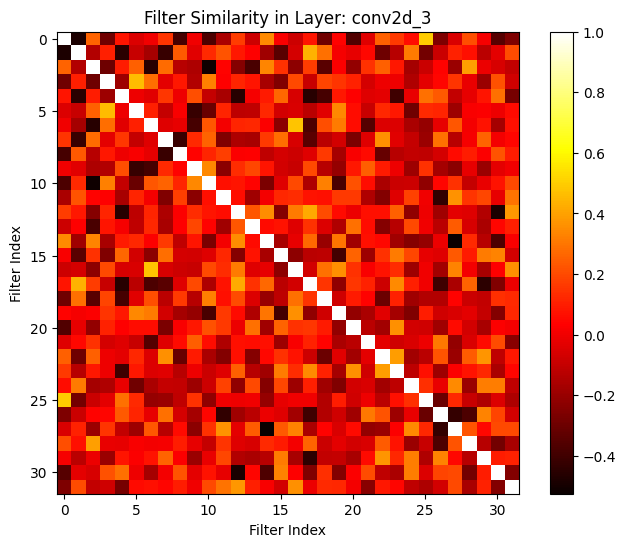

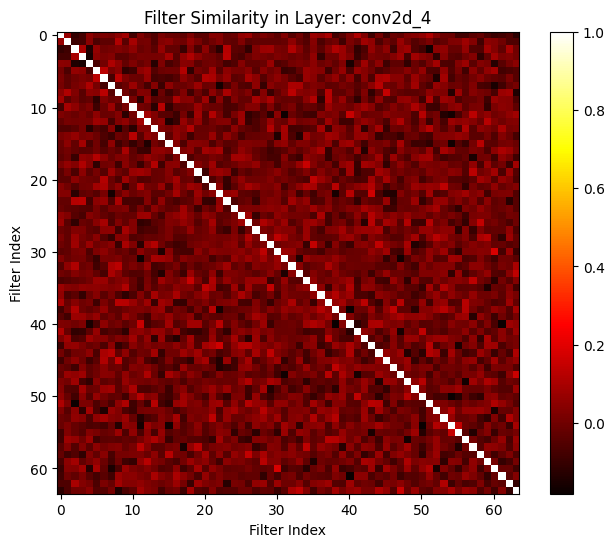

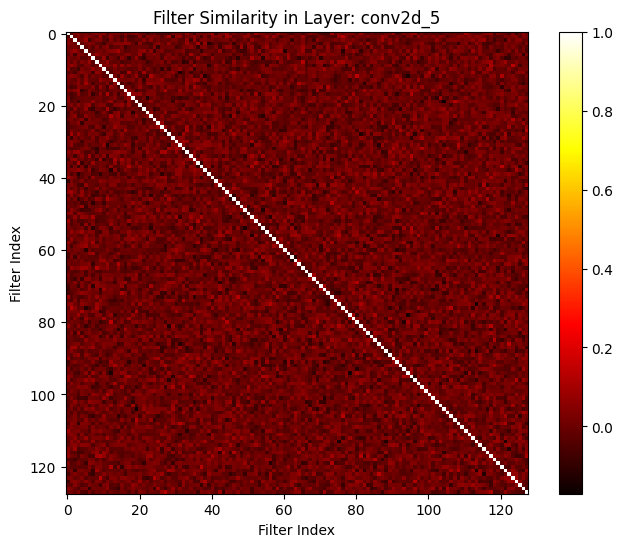

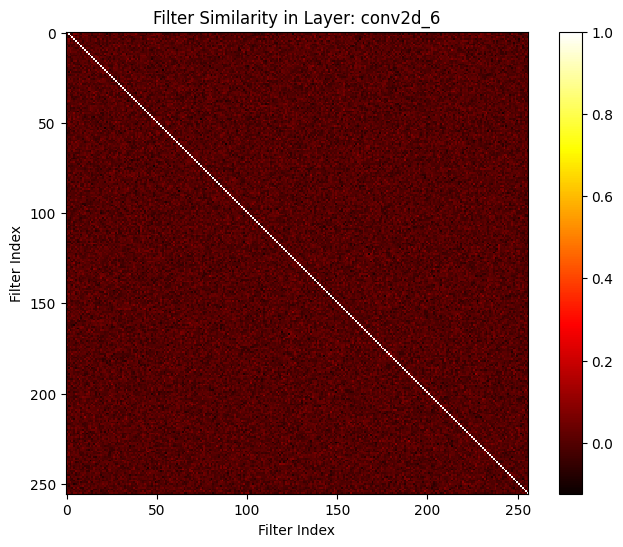

In [ ]:
analyze_redundant_filters(best_combined_model)

In [ ]:
# Save the trained model
best_combined_model.save("best_combined_model.h5")